# Topology run 7 after fidutial selection

## DEMO Run7


### April 2021, JAH

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt


In [3]:
import hipy.utils        as ut
import hipy.pltext       as pltext

import next.core.io        as nio
import next.core.selection as nsel

import next.eres.eres      as eres

In [4]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Mon Apr 19 12:44:05 2021


### load data

In [5]:
filename  = f'/home/hernando/data/demo/run7/dfesme_fidutial_combined.h5'
dft       = pd.read_hdf(filename, 'esme')
print('total number of events ', len(dft))

total number of events  913222


### Inspect DF

In [6]:
columns = list(dft.columns)
print(columns)
i = columns.index('evt_out_of_map') # problems with plotting, remove from the list to plot
columns.pop(i)
#pltext.df_inspect(dft, columns, ncolumns = 3)

['event', 'trackID', 'energy', 'length', 'numb_of_voxels', 'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'r_min', 'x_max', 'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'r_ave', 'extreme1_x', 'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z', 'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z', 'eblob1', 'eblob2', 'ovlp_blob_energy', 'dz_track', 'enecor', 'time', 'nS2', 'S1e', 'S2e', 'S2q', 'Nsipm', 'evt_energy', 'evt_ntrks', 'evt_nhits', 'evt_out_of_map', 'run']


'evt_out_of_map'

### selections and ranges

In [7]:
ranges = {'nS2'            : (1., 1.),
          'evt_out_of_map' : (False, False),
          'numb_of_tracks' : (1., 1.),
          'z_min'          : (15., 300.),
          'z_max'          : (15., 300.),
          'r_max'          : (0.,  55.),
          'energy'         : (0., 3.),
          'energy.cs'      : (0.65, 0.75),
          'energy.ds'      : (1.62, 1.85),
          'energy.ph'      : (2.00, 3.00),
          'dz_track.cs'    : (0., 60.),
          'dz_track.ds'    : (0., 120.),
         }
for key in ranges.keys():
    print(key, ranges[key])

nS2 (1.0, 1.0)
evt_out_of_map (False, False)
numb_of_tracks (1.0, 1.0)
z_min (15.0, 300.0)
z_max (15.0, 300.0)
r_max (0.0, 55.0)
energy (0.0, 3.0)
energy.cs (0.65, 0.75)
energy.ds (1.62, 1.85)
energy.ph (2.0, 3.0)
dz_track.cs (0.0, 60.0)
dz_track.ds (0.0, 120.0)


In [8]:
selections = nsel.Selections(dft, ranges)

### Indentify where is the Ds in z, x, y

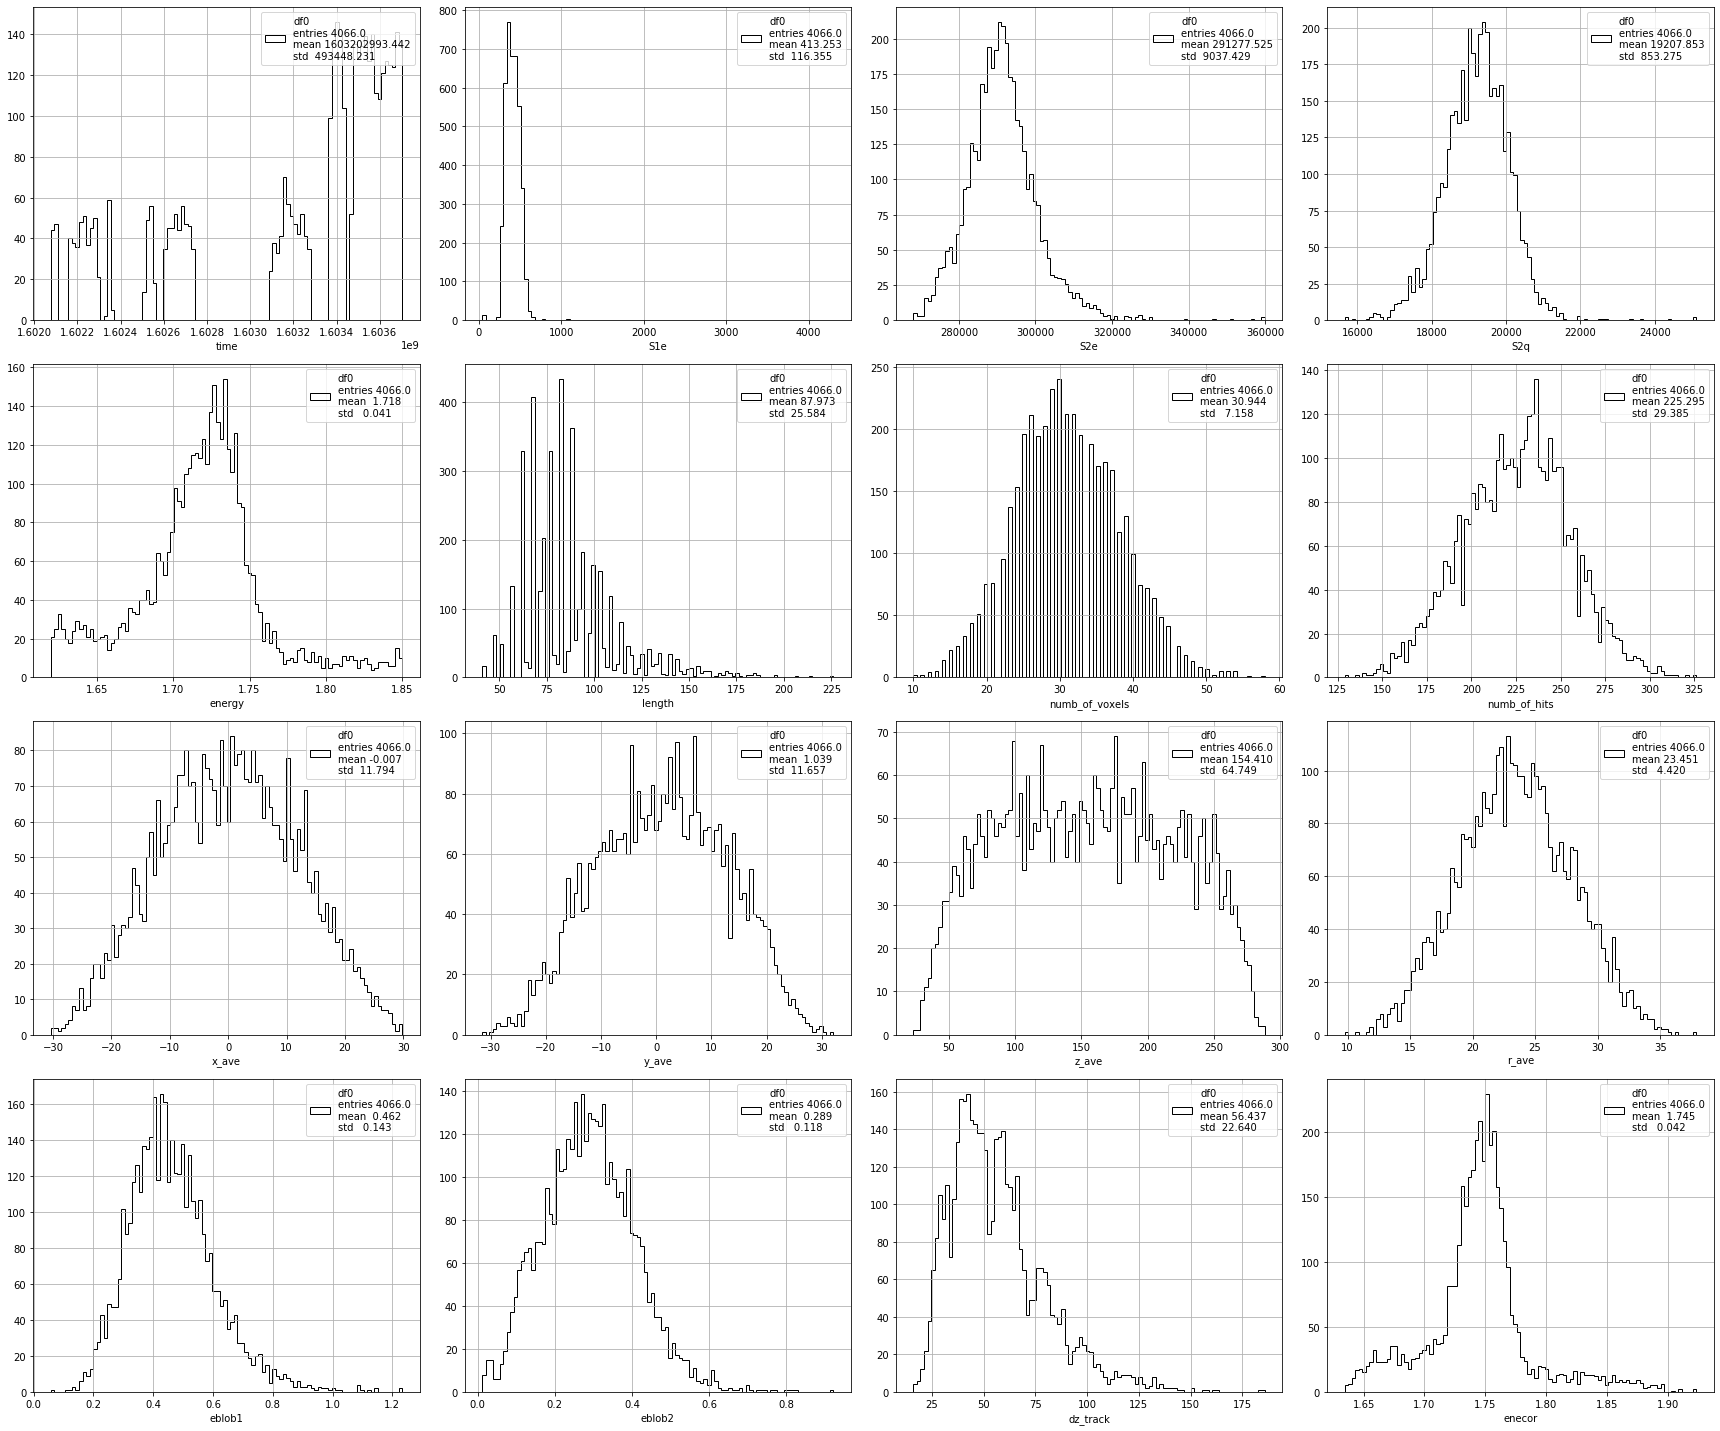

In [9]:
sel = selections['energy.ds']

labels = ['time', 'S1e', 'S2e', 'S2q',
          'energy', 'length', 'numb_of_voxels', 'numb_of_hits',
          'x_ave', 'y_ave', 'z_ave', 'r_ave',
          'eblob1', 'eblob2',
          'dz_track', 'enecor']
pltext.df_inspect(dft[sel], labels, ncolumns = 4)

**Conclusions**

   * DS is equaly distributed in x, y, z
   
   * Cs is located at z = 170 cm, (most likely where the source is) and other two positions (90, 260), why?

## Energy resolution - Delta z correction

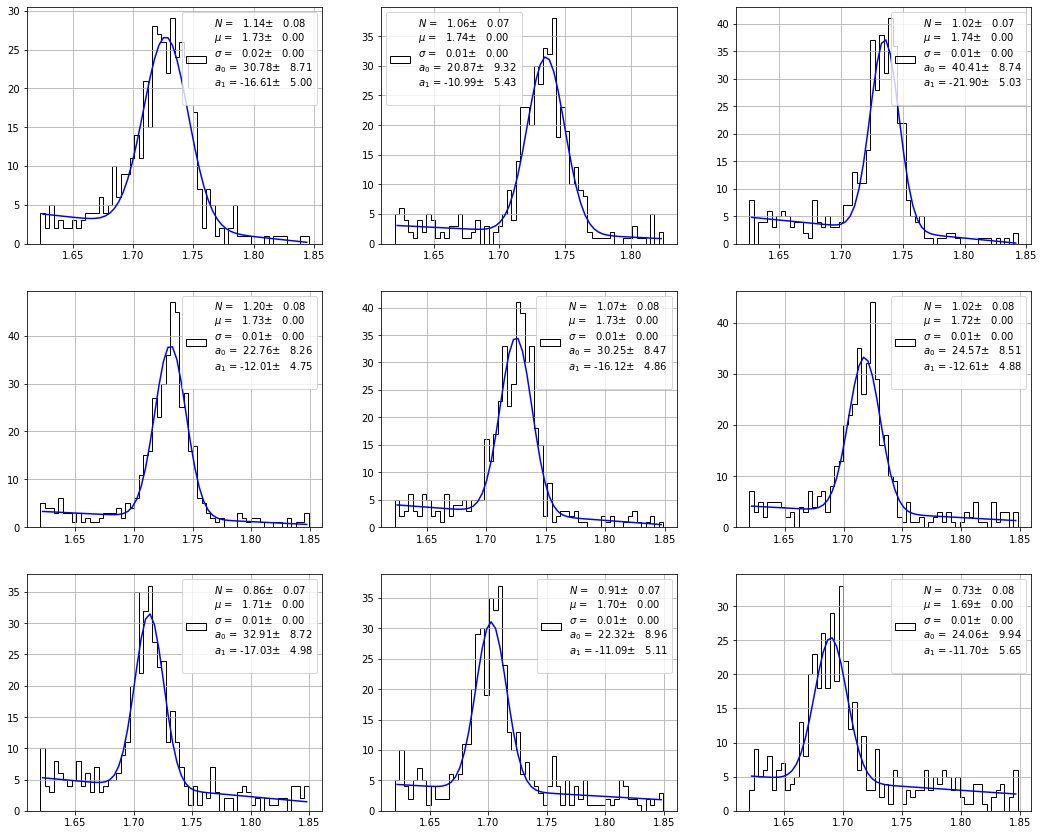

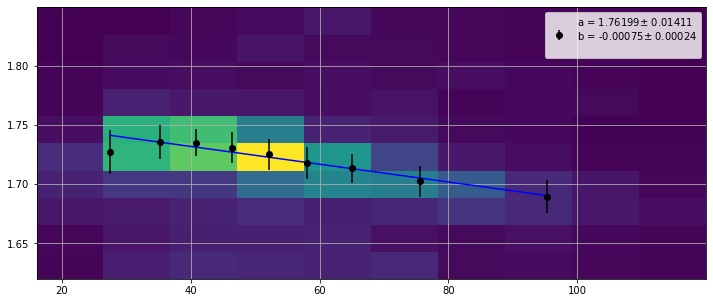

In [10]:
sel   = selections.logical_and(('energy.ds', 'dz_track.ds'), 'ds')
names = ('energy', 'dz_track')

ene, dz = [dft[sel][name].values for name in names]

nbins = 10
p0s   = 10*(None,)

xmed, mus, sigs, pars, upars = eres.dz_effect(dz, ene,  nbins, p0s = p0s, plot = True)

In [11]:
alpha = abs(pars[1]/pars[0])
scale = 1.
print('alpha, scale', alpha, scale)

ene, dz = dft.energy.values, dft.dz_track.values
enecor  = eres.dz_energy_correction(ene, dz, alpha, scale)
dft.enecor = np.copy(enecor)
ranges['enecor.cs'] = (0.66, 0.75)
ranges['enecor.ds'] = (1.65, 1.87)
selections.set_range('enecor.cs', ranges['enecor.cs']);
selections.set_range('enecor.ds', ranges['enecor.ds']);

alpha, scale 0.000426350415376922 1.0


(0.7141940334248973, 0.00788457268829298, 8.399995209440496e-05, 2.5943574085370646, 0.02763953186156234)
resolution R = 2.5944 +- 0.02764
(1.7617093869167146, 0.014276702784183633, 0.00030721332305969296, 1.9044146436405198, 0.040980159074580046)
resolution R = 1.9044 +- 0.04098


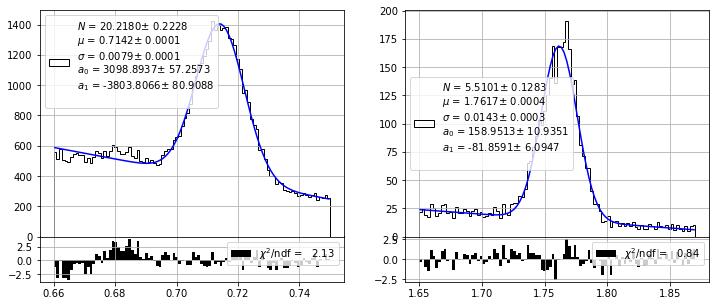

In [12]:
ename   = 'enecor'
eranges = [ranges[name] for name in (ename + '.cs', ename + '.ds')]
subplot = pltext.canvas(len(eranges))
for i, erange in enumerate(eranges):
    subplot(i + 1)
    pars = eres.energy_fit(dft[ename].values, 100, range = erange, plot = True)
    print(pars)
    print('resolution R = {0:6.4f} +- {1:6.5f}'.format(*pars[-2:]))

### Blob distributions

3078


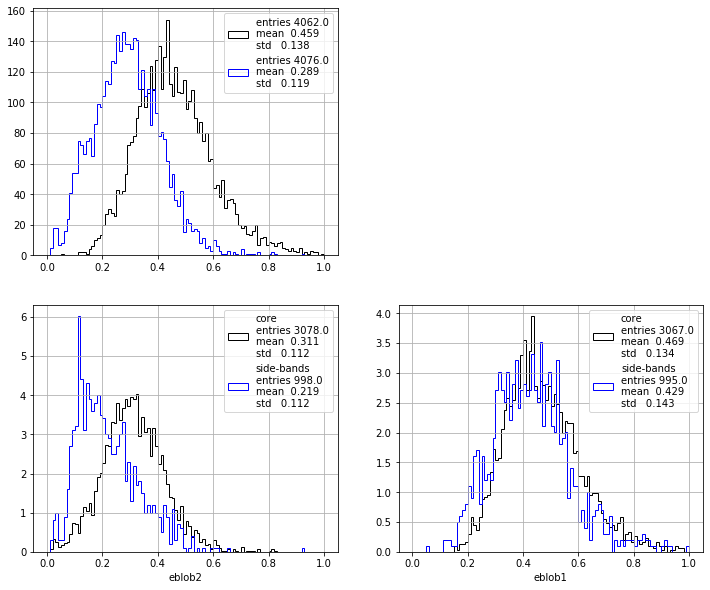

In [13]:
sel    = selections['enecor.ds']
erange = ranges['enecor.ds']
enecor = dft.enecor[sel].values 
usel   = ut.in_range(enecor, (1.72, 1.8))
print(np.sum(usel))

eblob1, eblob2 = [dft[sel][name].values for name in ('eblob1', 'eblob2')]

subplot = pltext.canvas(4)
subplot(1)
pltext.hist(eblob1, 100, range = (0., 1.));
pltext.hist(eblob2, 100, range = (0., 1.));

subplot(3)
pltext.hist(eblob2[ usel], 100, range = (0., 1.), density = True, label = 'core');
pltext.hist(eblob2[~usel], 100, range = (0., 1.), density = True, label = 'side-bands');
plt.xlabel('eblob2');

subplot(4)
pltext.hist(eblob1[ usel], 100, range = (0., 1.), density = True, label = 'core');
pltext.hist(eblob1[~usel], 100, range = (0., 1.), density = True, label = 'side-bands');
plt.xlabel('eblob1'); 

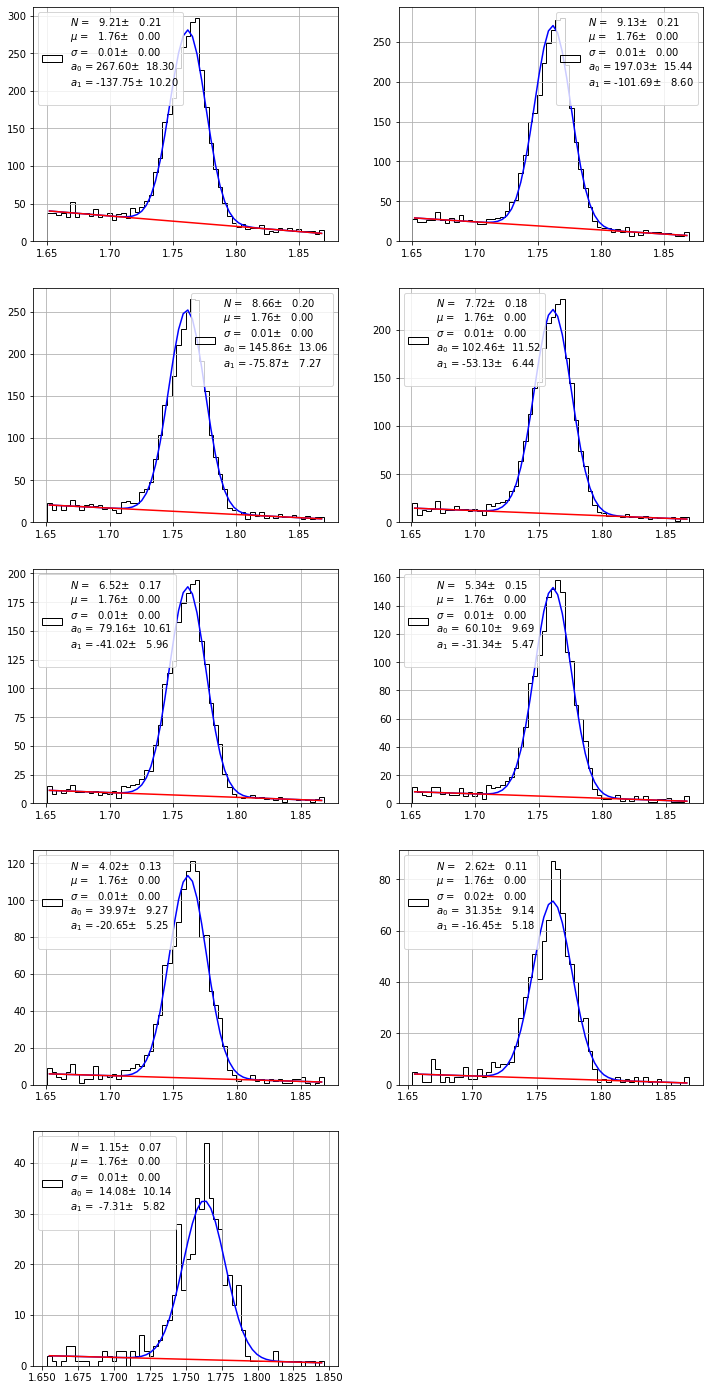

In [14]:
ename  = 'enecor'
nscan  = 10
mbins  = 60
sel    = selections[ename + '.ds']
ene, eblob1, eblob2 = [dft[sel][name].values for name in ('enecor', 'eblob1', 'eblob2')]

eblob2_scan, nsigs, nbkgs = eres.ds_eblob2scan(ene, eblob2, nscan, mbins, plot = True)

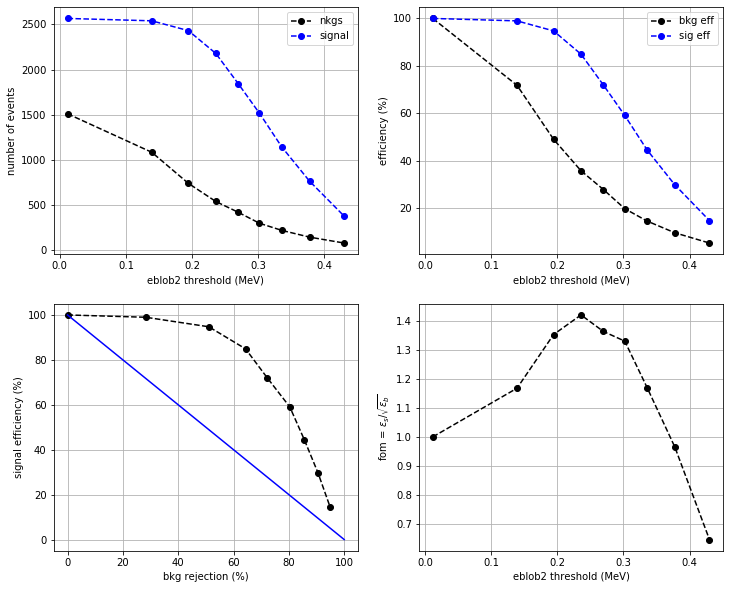

In [15]:
eres.plt_eblob2scan(eblob2_scan, nsigs, nbkgs)

ValueError: x and y must have same first dimension, but have shapes (8,) and (9,)

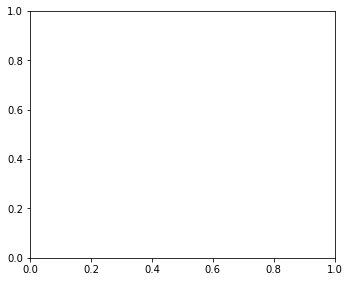

In [16]:
esigs = 100. * nsigs/nsigs[0]
ebkgs = 100. * nbkgs/nbkgs[0]

subplot = pltext.canvas(4)

subplot(1)
plt.plot(eblob2_scan[:-1], nbkgs, marker = 'o', ls = '--', label = 'nkgs')
plt.plot(eblob2_scan[:-1], nsigs, marker = 'o', ls = '--', label = 'signal')
plt.xlabel('eblob2 threshold (MeV)'); plt.ylabel('number of events'); 
plt.grid(); plt.legend();

subplot(2)
plt.plot(eblob2_scan[:-1], ebkgs, marker = 'o', ls = '--', label = 'bkg eff')
plt.plot(eblob2_scan[:-1], esigs, marker = 'o', ls = '--', label = 'sig eff')
plt.xlabel('eblob2 threshold (MeV)'); plt.ylabel('efficiency (%)'); 
plt.grid(); plt.legend();

subplot(3)
plt.plot(100. - ebkgs, esigs, marker = 'o', ls = '--');
plt.xlabel('bkg rejection (%)'); plt.ylabel('signal efficiency (%)')
vs = np.linspace(0., 100., 10)
plt.plot(100. - vs, vs); plt.grid(); 

subplot(4)
fom  = nsigs/np.sqrt(nbkgs)
fom2 = 0.01* esigs/np.sqrt(0.01 * ebkgs)
#plt.plot(eblob2_scan[:-1], fom, marker = 'o', ls = '--', label = 'events sigma/sqrt(bkg)')
plt.plot(eblob2_scan[:-1], fom2, marker = 'o', ls = '--', label = 'fom')
plt.xlabel('eblob2 threshold (MeV)'); plt.ylabel('fom = $\epsilon_s/\sqrt{\epsilon_b}$'); 
plt.grid();